In [947]:
import matplotlib.pyplot as plt
import pandas as pd

In [948]:
df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-02-22/freedom.csv')

In [949]:
df.head()

,country,year,CL,PR,Status,Region_Code,Region_Name,is_ldc
0,Afghanistan,1995,7,7,NF,142,Asia,1
1,Afghanistan,1996,7,7,NF,142,Asia,1
2,Afghanistan,1997,7,7,NF,142,Asia,1
3,Afghanistan,1998,7,7,NF,142,Asia,1
4,Afghanistan,1999,7,7,NF,142,Asia,1


The dataset itself does not contain any country codes. I needed them to plot values on the world map, so had to import a library

In [950]:
countries = {}

# this will give a dict of all names and three-letter codes
for country in pycountry.countries:
      countries[country.name] = country.alpha_3

In [951]:
def get_code(object):
    "function for pd.apply, turn countries into codes"
    return countries.get(object, 'Unknown code')

In order to paint countries on the mao, I needed their real names. In the datase some of them are a bit changed, so I had to do it manually. Probably, there is more, I hope they're not too relevant

In [952]:
df["country"] = df["country"].replace({"United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
                          "United States of America": "United States",
                          "Bolivia (Plurinational State of)": "Bolivia, Plurinational State of",
                          "Democratic Republic of the Congo": "Congo, The Democratic Republic of the",
                          "CÃƒÂ´te dÃ¢â‚¬â„¢Ivoire": "Côte d'Ivoire",
                          "Venezuela (Bolivarian Republic of)": "Venezuela, Bolivarian Republic of",
                          "Iran (Islamic Republic of)": "Iran, Islamic Republic of",
                          "Republic of Korea": "Korea, Republic of",
                          "Democratic People's Republic of Korea": "Korea, Democratic People's Republic of",
                          "United Republic of Tanzania": "Tanzania, United Republic of"})

In [953]:
df["Code"] = df.country.apply(get_code)

Overall liberty rating is counted as a sum of CL - civil liberties ans PR - political rights. Text row is for showing it properly on the map

In [954]:
df["liberty_rating"] = df.CL + df.PR
df['text'] = df['CL'].astype("string") + ' Civil liberties' + '<br>' + df['PR'].astype("string") +' Political rights'

Slice for 2020 is going to be useful later

In [955]:
df_20 = df[df.year == 2020]

In [1074]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations = df_20['Code'],
    z = df_20['liberty_rating'],
    text = df_20['text'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Global (un)freedom',
))

fig.update_layout(
    title_text='2020 Freedom level chart',
    margin=dict(l=20, r=20, t=40, b=20),
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        showarrow = True
    )]
)

fig.update_layout(hovermode="y")

I would expect that everything'd be red around europe and USA, and that is actually the way it is. Mongolia is an interesting exception, being almsot white and Venezuela, being almost red

Different dataset to check liberty levels of Russia

In [967]:
rus_df = df[df.country == "Russian Federation"]

I wanted to create a radar chart but considering there's on;y 2 dimensions, it would look like a line. I added values so that account for the corners of a figure, make it more visible.

In [968]:
rus_df[" "] = rus_df["  "] = rus_df["liberty_rating"]/4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



That's a trick I saw somewhere to create animations, basically I had to gather all the variables and than split them by attribute, exmaple below

In [969]:
rus_df = rus_df[["CL", " ", "PR", "  ", "year"]]
med = rus_df.groupby('year').median()
med.reset_index(inplace=True)

In [970]:
plot_data = pd.melt(med, id_vars='year', var_name='attribute', value_name='attribute_value')
plot_data

,year,attribute,attribute_value
0,1995,CL,4.00
1,1996,CL,4.00
2,1997,CL,4.00
3,1998,CL,4.00
4,1999,CL,5.00
...,...,...,...
99,2016,,3.25
100,2017,,3.25
101,2018,,3.25
102,2019,,3.25


In [974]:
fig = px.line_polar(plot_data,
                    r='attribute_value', 
                    theta='attribute',
                    line_close=True, 
                    animation_frame = 'year',
                    title='Russian liberty rating by year',
                    template = 'ggplot2'
             )
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 7]
    )),
  showlegend=False
)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
fig.show()

As seen above, Russia changed im a balanced manner over the years, although I was thinking that only political rights have changed, didn't notice anything other than that

Then I wanted to take a look at countries that've recently experienced a regime change, to see whether it's been reflected in the dataset

In [975]:
danger_states = ["Russian Federation", "Iraq", "Mali", "Tunisia"]

In [976]:
danger_df = df[df.country.isin(danger_states)]

Text(0.5, 0.98, 'Countries frredom rating changes after regime shifts')

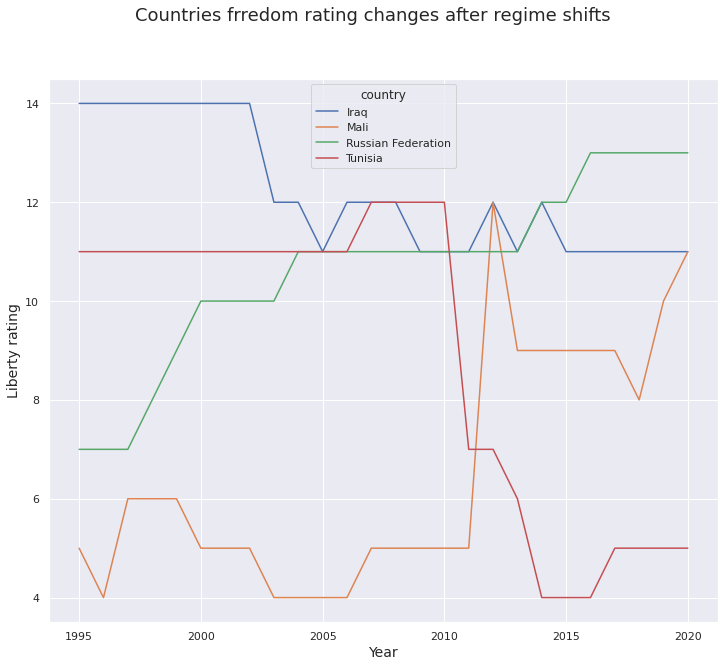

In [981]:
plt.figure(figsize=(12,10))
sns.lineplot(x="year", y="liberty_rating", hue="country", data=danger_df)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Liberty rating', fontsize=14)
plt.suptitle('Countries frredom rating changes after regime shifts', fontsize=18)

Countries that've swapped to democracy did indeed become more liberal, and vice versa, but the degree of a change is somewhat unclear. Might be related to internal politics

At that moment I started questioning the reasoning of the values CL and PR, so I decided to change their correlation, they seemed to mean almost the same thing

In [1068]:
corr_df = df[["CL", "PR"]]

This is a little piece of code I used to calculate weights - how many times a given pair of variables was encountered in the dataset

In [1070]:
corr_df["paired"] = corr_df[corr_df.columns].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
weights = corr_df.paired.value_counts().reset_index()
weights.columns = ['paired', 'weight']
weighted_df = pd.merge(corr_df, weights, on='paired')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



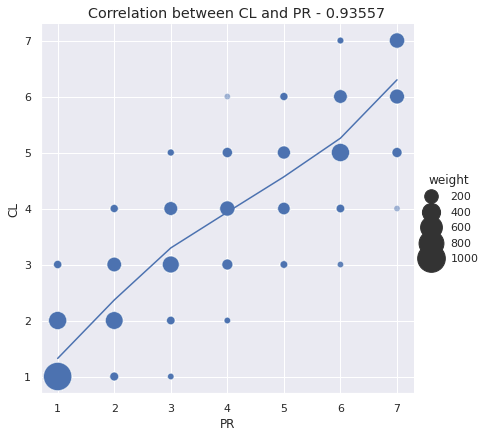

In [1072]:
sns.relplot(x="PR", y="CL", size="weight",
            sizes=(40, 800), alpha=.5, palette="muted",
            height=6, data=weighted_df)
sns.lineplot(x="PR", y="CL", data=corr_df.groupby("PR").mean().reset_index(), legend=False)

plt.suptitle(f"Correlation between CL and PR - {round(corr_df.corr().values[0][1], 5)}",
             y=1.01)
plt.show()

Suspicions appeared to be true - the variables are heavilly correlated, exceptions are few, which is proven by the weights

Nex thing I wanted to check - unfreedom in regions. I was hoping to see an increase in Asia, because of the tension on the Near East, Syria, for example

In [989]:
regions_df = df.groupby(["Region_Name", "year"]).mean()

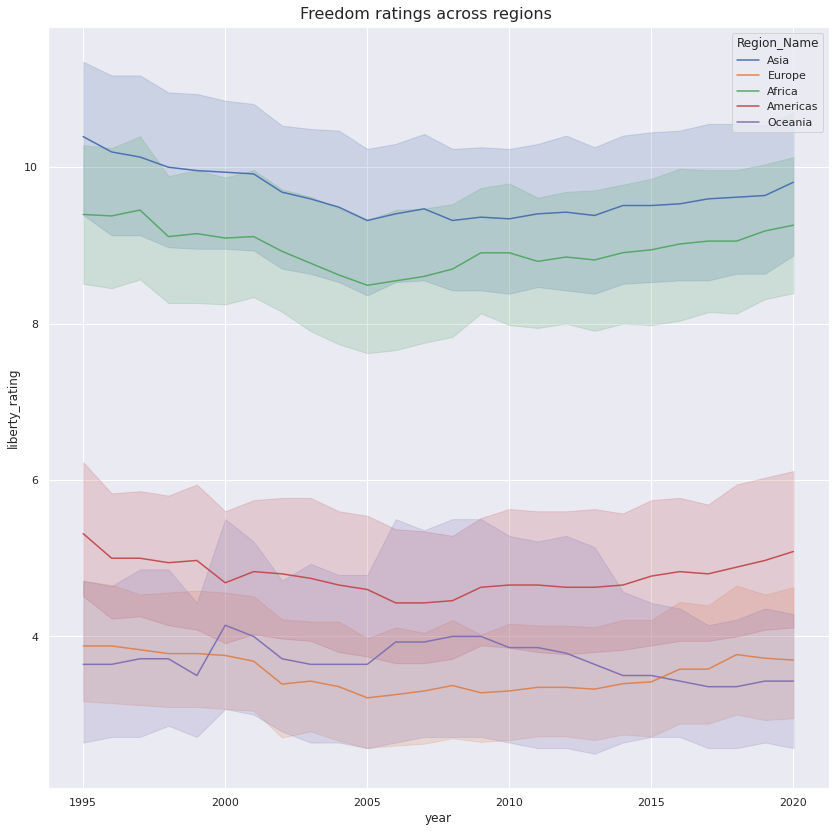

In [1078]:
# Unfortunately sns.FacetGrid doesn't scale too well, had to improvise

fig, axs = plt.subplots(figsize=(14, 14))
colors = ["blue", "purple", "red", "orange", "teal"]

sns.lineplot(x="year", y="liberty_rating", hue="Region_Name", data=df)

fig.suptitle('Freedom ratings across regions', fontsize=16, y=0.9)

plt.show()

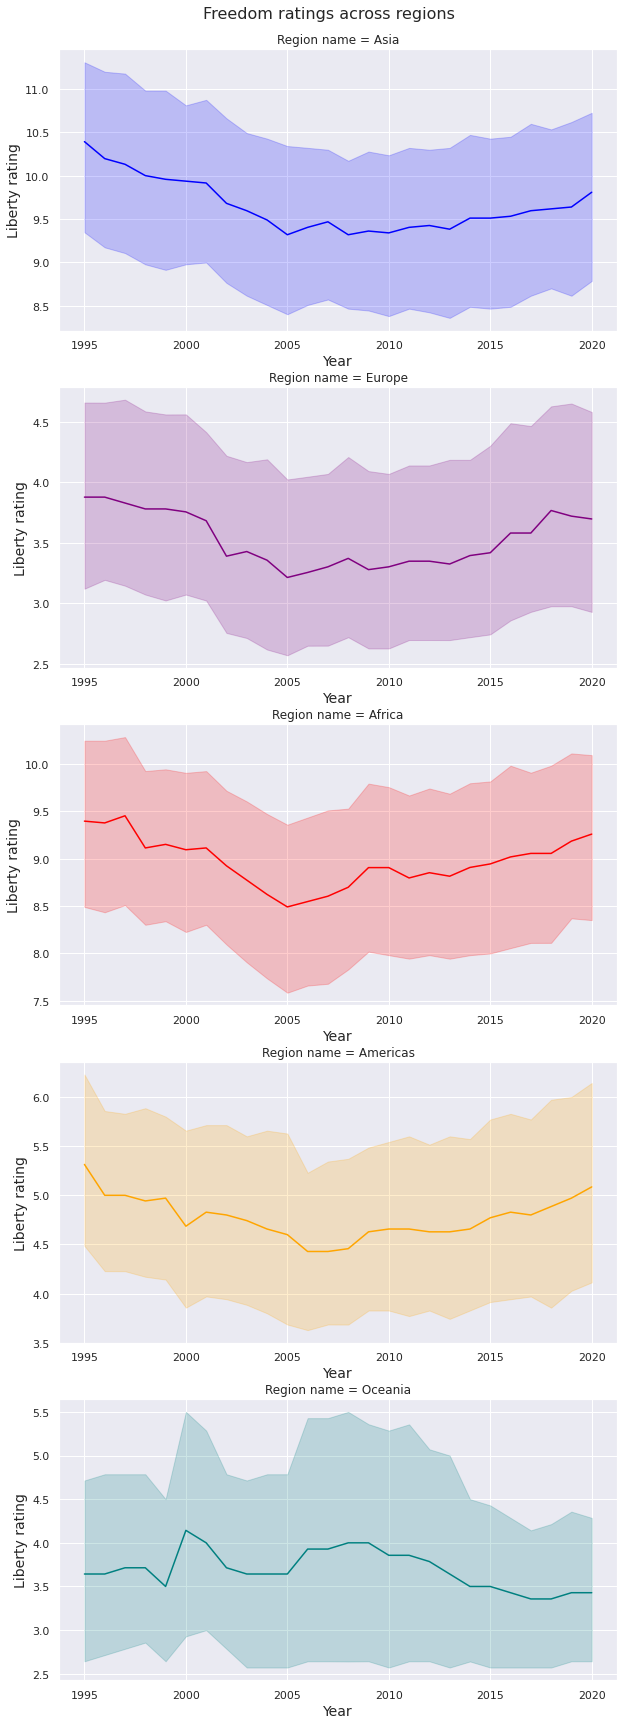

In [1009]:
# Unfortunately sns.FacetGrid doesn't scale too well, had to improvise

fig, axs = plt.subplots(figsize=(10, 30), nrows=5)
colors = ["blue", "purple", "red", "orange", "teal"]

for i, region in enumerate(df["Region_Name"].unique()):
    sns.lineplot(x="year", y="liberty_rating",
                 data=df[df["Region_Name"] == region], ax=axs[i],
                 color=colors[i])
    axs[i].set_title(f"Region name = {region}")
    axs[i].set_ylabel('Liberty rating', fontsize=14)
    axs[i].set_xlabel('Year', fontsize=14)

fig.suptitle('Freedom ratings across regions', fontsize=16, y=0.9)

plt.show()

Graphs tell us that almost everywhere freedom level stayed roughly the same in the last 25 years. Oceania and Asia is the only exception, hypothesis was rejected

But then why are the news telling about rise of authoritarian regimes? I wanted to check global levels first, dependency on civilization second (probably more civilized means less free), and 'absolute' unfreedom value (probably Asia once again), in order to determine which regions 'suffer' the most

In [1088]:
df_20["is_ldc"] = df_20["is_ldc"].replace({0: "Noncivilized",
                                            1: "Civilized"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1090]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df1 = df_20.groupby("is_ldc").mean()["liberty_rating"]
df2 = df_20.groupby("Region_Name").sum()["liberty_rating"]

fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Pie(labels=df1.index, values=df1.values,
                     title="Civilization influence on liberty",
                     hole=.5, domain=dict(x=[0, 0.33])))
fig.add_trace(go.Scatter(x=df.year,
                         y=df.groupby("year").mean()["liberty_rating"].values,
                         mode='lines',
                         name='Global',
                         line=dict(color='black', width=4)),
              row=1, col=2)
fig.add_trace(go.Pie(labels=df2.index, values=df2.values,
                     title="'Ansolute' unfreedom by region",
                     hole=.5, domain=dict(x=[0.66, 1])))
fig.update_layout(uniformtext_minsize=14, uniformtext_mode='hide')
fig.update_layout(
    title={
        'text': "General liberty level trend",
        'y':0.9,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Global trend does increase in the latest years, but not overall, news seem to be partially true. Civilzation does have an impact on liberty levels. And Asia and Africa do matter the most, Oceania is too small to have any, so I would make a conclusion that nothing serious happened recently, given the previous plots

I missed the classification by regimes in the dataset, so I downloaded it specifically. Then created a combined political_df for 2020 years with regines

In [1041]:
temp = pd.read_csv("political-regime.csv")
temp = temp[temp.Year == 2020]
pol_df = pd.merge(df_20, temp, on="Code")

# it wasn't specified initially, so I did it myself
pol_df["regime_row_owid"] = pol_df["regime_row_owid"].replace({0: "Closed autocracy",
                                                               1: "Electoral autocracy",
                                                               2: "Electoral democracy",
                                                               3: "liberal democracy"})

# and N. Korea has to be renamed for later purposes
pol_df["country"] = pol_df["country"].replace({
                          "Korea, Democratic People's Republic of": "Northern Korea"})

Firstly, I wanted to see whole statistics on regimes, I expectex the majority of countries to be electoral democracies, relying on intuition

In [1042]:
vals = pol_df["regime_row_owid"].value_counts()

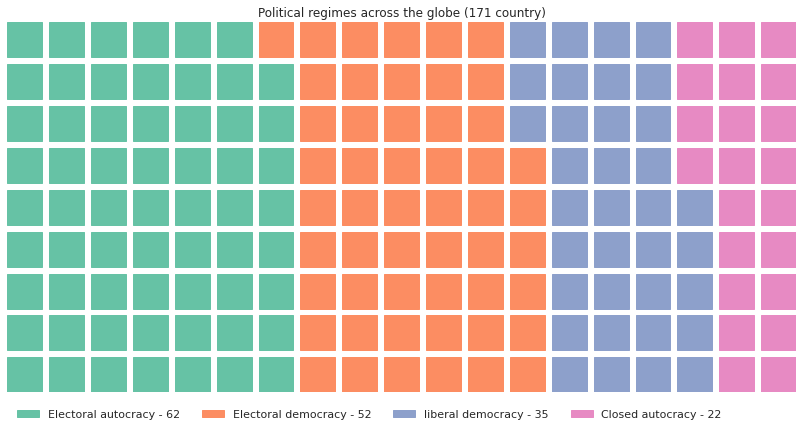

In [1043]:
from pywaffle import Waffle

fig = plt.figure(
    figsize=(12,10),
    FigureClass=Waffle, 
    rows=9, 
    values=vals, 
    title={'label': 'Political regimes across the globe (171 country)', 'loc': 'center'},
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.1), 'ncol': len(vals), 'framealpha': 0},
    labels=[f'Electoral autocracy - {vals[0]}', f'Electoral democracy - {vals[1]}',
            f'liberal democracy - {vals[2]}', f'Closed autocracy - {vals[3]}']
)
plt.show()

Prediction was wrong, most of the countries are autocracies

To show them on the graph I used radial barplot. I expected that democracies will be around 3-4, autocracies around 9-10, no matter the elections

In [1044]:
radial_df = pol_df.groupby("regime_row_owid").mean()
radial_df

,year,CL,PR,Region_Code,is_ldc,liberty_rating,Year
regime_row_owid,,,,,,,
Closed autocracy,2020.0,5.954545,6.727273,85.500000,0.318182,12.681818,2020.0
Electoral autocracy,2020.0,4.887097,5.306452,65.338710,0.387097,10.193548,2020.0
Electoral democracy,2020.0,2.788462,2.461538,62.865385,0.250000,5.250000,2020.0
liberal democracy,2020.0,1.342857,1.228571,105.885714,0.000000,2.571429,2020.0


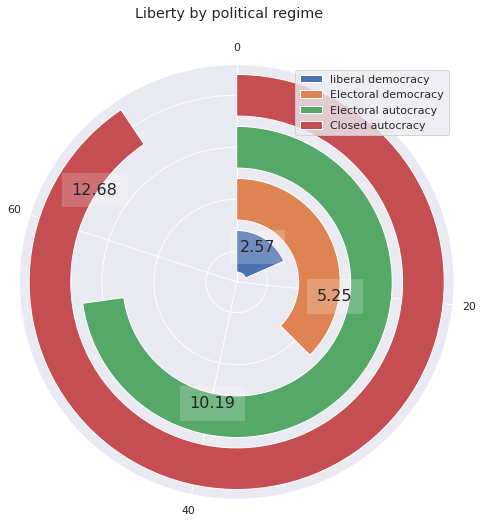

In [1073]:
import math

_, ax = plt.subplots(figsize=(8,8))
ax = plt.subplot(projection='polar')

for i in range(4):
    ax.barh(i, math.radians(radial_df.iloc[3-i]["liberty_rating"]*360/14),
            label = radial_df.index[3-i])
    ax.text(.1+i*1.7, 0+i*1,
            f"{round(radial_df.iloc[3-i]['liberty_rating'], 2)}", fontsize=16,
            bbox={'facecolor':'white','alpha':.2,'edgecolor':'none','pad':10})
    

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
ax.set_thetagrids([0, 96, 192, 288], labels=[0, 20, 40, 60])
ax.set_rgrids([0, 1, 2, 3], labels=['a', 'b', 'c', 'd'])

plt.grid("On")
plt.suptitle("Liberty by political regime")
plt.legend()
plt.show()

In reality numbers are splitted unequally. Therefore, it probably might be used to create a regime classifier, I wish I had more time to train it (

Next goes the overall rating to determine the worst and the best countries. It's quite clunky, but on the other hand it is dybnamic and can be adjsuted to show only a number of countires if needed. I would expect African and Asian countries to dominate the top throughout the years, while Scandinavia and East Europe should reside on the bottom

In [1047]:
fig = px.bar(df,
         x="liberty_rating", 
         y="country",
         animation_frame="year",
         range_y=[0,14],
         width=1200, height=1000)
fig.update_layout(
  showlegend=False
)
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total descending'})
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig.show()

To show the rating in a better way, I created a self-made top from subsets of df

In [1048]:
worst = df[df.year == 2020].sort_values("liberty_rating", ascending=False).iloc[:5]

In [1049]:
best = df[df.year == 2020].sort_values("liberty_rating", ascending=True).iloc[:5]

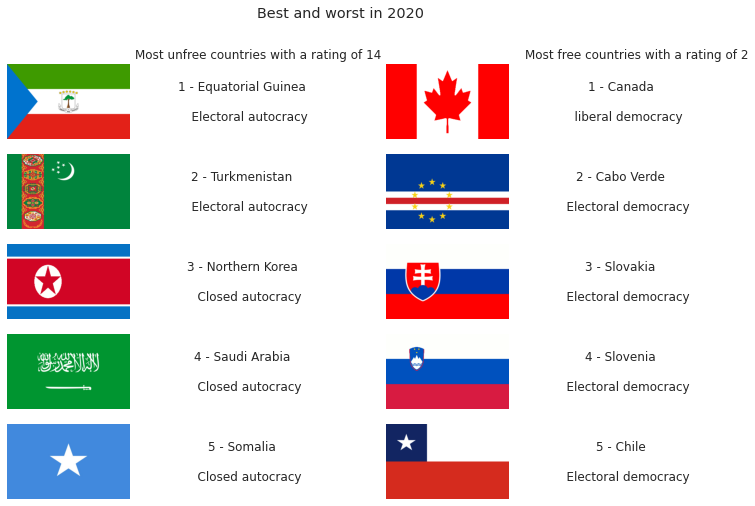

In [1056]:
from PIL import Image

fig = plt.figure(figsize=(13, 8))
pics = ["Chile", "Somalia", "Slovenia", "Saudi Arabia", "Slovakia",
        "Northern Korea", "Cabo Verde", 'Turkmenistan', "Canada", "Equatorial Guinea"][::-1]
h = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5]
columns = 4
rows = 5

for i, j in enumerate(range(1, 21, 2)):
    img = Image.open(pics[i]+".png")
    img = img.resize((360, 220))
    fig.add_subplot(rows, columns, j)
    ax.grid(False)
    plt.axis('off')
    plt.imshow(img)

    f_string = f"""{h[i]} - {pics[i]}\n
    {pol_df[pol_df.country == pics[i]]["regime_row_owid"].values[0]}"""

    ax = fig.add_subplot(rows, columns, j+1)
    if i == 0:
        ax.set_title("Most unfree countries with a rating of 14")
    elif i == 1:
        ax.set_title("Most free countries with a rating of 2")
    ax.text(.4,.5, f_string,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='center', va='center') 
    ax.grid(False)
    plt.axis('off')

# Hide grid lines

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle("Best and worst in 2020")

plt.show()

As we can see Asia and Africa are the worst places, but the best are surprisingly Slavic Countries and Americas